# Decision Tree

### import thư viện

In [22]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import graphviz



### import dữ liệu

In [3]:
train_df = pd.read_csv('./data/train.csv')

test_df = pd.read_csv('./data/test.csv')


In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Feature engineering

In [5]:
def title(name):
    return title_group(name.split(', ')[1].split('. ')[0].strip())

def title_group(title):
    if title in ['Mr']:
        return 'Mr'
    elif title in ['Miss', 'Ms', 'Mlle']:
        return 'Miss'
    elif title in ['Mrs', 'Mme']:
        return 'Mrs'
    elif title in ['Master']:
        return 'Master'
    else:
        return 'Other'

def deck(cabin):
    return cabin[0]

train_df['Age'] = pd.cut(train_df['Age'], bins=[0,12,18,30,50,120], labels=['Child', 'Teenager', 'Young adult', 'Adult', 'Senior'])
test_df['Age'] = pd.cut(test_df['Age'], bins=[0,12,18,30,50,120], labels=['Child', 'Teenager', 'Young adult', 'Adult', 'Senior'])

train_df['Fare_group'] = pd.cut(train_df['Fare'], bins=[0,50,100,300,1000], labels=['Low', 'Medium', 'High', 'Very High'])
test_df['Fare_group'] = pd.cut(test_df['Fare'], bins=[0,50,100,300,1000], labels=['Low', 'Medium', 'High', 'Very High'])

train_df['Family_size'] = train_df['Parch'] + train_df['SibSp'] + 1
test_df['Family_size'] = test_df['Parch'] + test_df['SibSp'] + 1

train_df['Title'] = train_df['Name'].apply(title)
test_df['Title'] = test_df['Name'].apply(title)

train_df['Deck'] = train_df['Cabin'].apply(lambda x: deck(x) if pd.notnull(x) else 'U')
test_df['Deck'] = test_df['Cabin'].apply(lambda x: deck(x) if pd.notnull(x) else 'U')


In [6]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_group,Family_size,Title,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,Young adult,1,0,A/5 21171,7.2500,NaN,S,Low,2,Mr,U
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,Adult,1,0,PC 17599,71.2833,C85,C,Medium,2,Mrs,C
2,3,1,3,"Heikkinen, Miss. Laina",female,Young adult,0,0,STON/O2. 3101282,7.9250,NaN,S,Low,1,Miss,U
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,Adult,1,0,113803,53.1000,C123,S,Medium,2,Mrs,C
4,5,0,3,"Allen, Mr. William Henry",male,Adult,0,0,373450,8.0500,NaN,S,Low,1,Mr,U


In [7]:
drop_features = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']

train_df.drop(columns=drop_features, inplace=True)
test_df.drop(columns=drop_features, inplace=True)

In [8]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Fare_group,Family_size,Title,Deck
0,0,3,male,Young adult,7.2500,S,Low,2,Mr,U
1,1,1,female,Adult,71.2833,C,Medium,2,Mrs,C
2,1,3,female,Young adult,7.9250,S,Low,1,Miss,U
3,1,1,female,Adult,53.1000,S,Medium,2,Mrs,C
4,0,3,male,Adult,8.0500,S,Low,1,Mr,U


## Preprocessing

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_features = ['Fare', 'Family_size']
cat_features = ['Pclass', 'Sex', 'Age', 'Embarked', 'Fare_group', 'Title', 'Deck']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

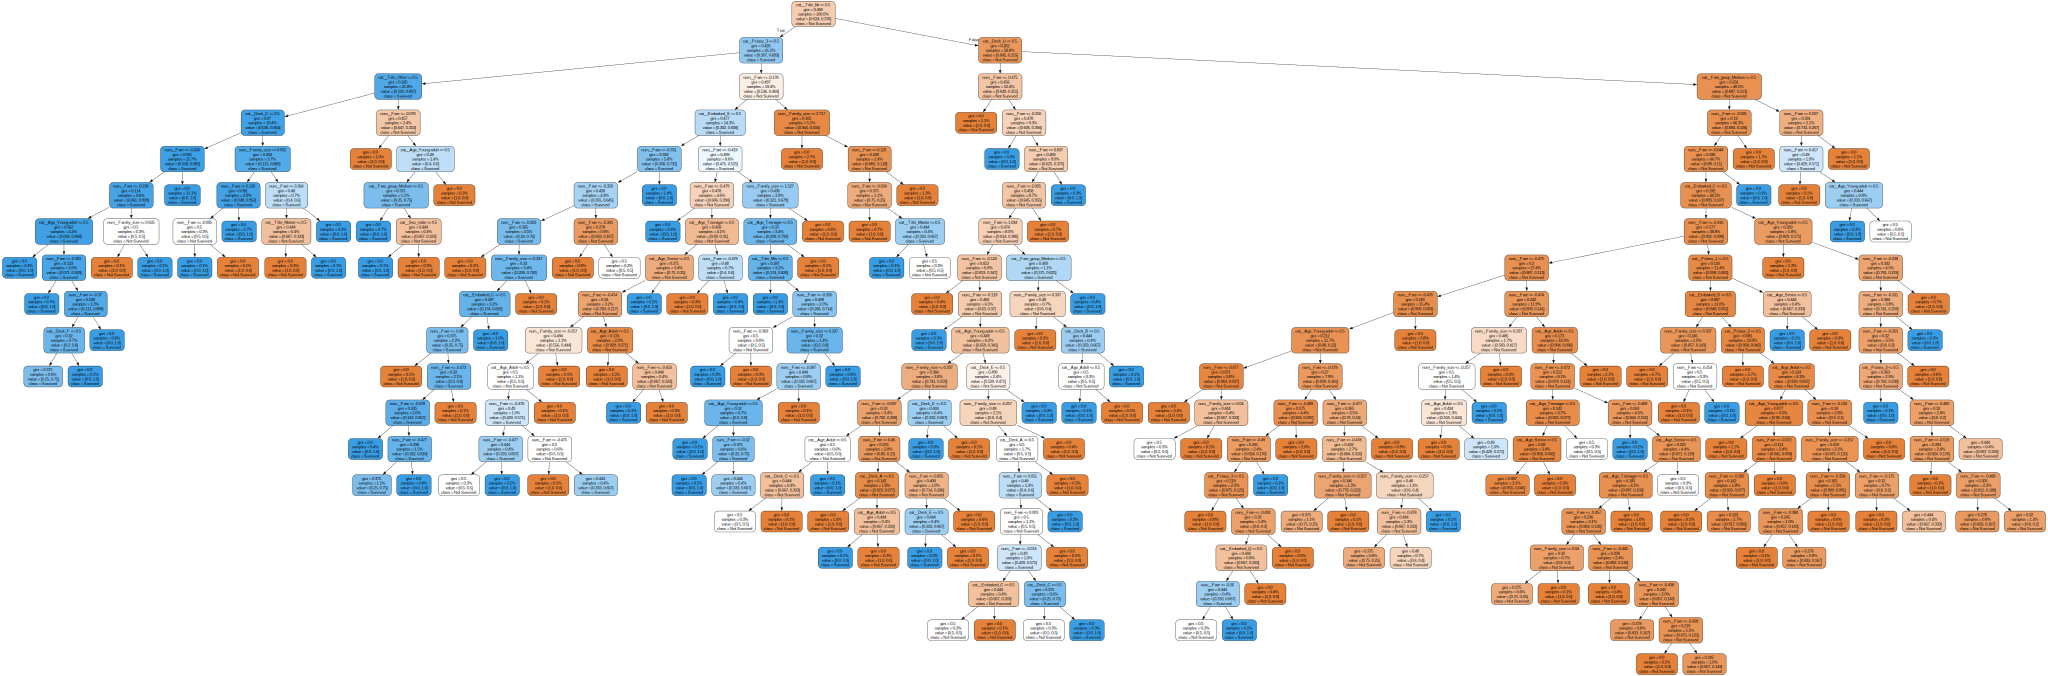

In [13]:
x = train_df.drop(columns='Survived')
y = train_df['Survived']

os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

x_train, x_valid, y_train, y_valid = train_test_split(x,y, train_size=0.8, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42))
])

pipeline.fit(x_train, y_train)

model = pipeline.named_steps['model']

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

dot_data = export_graphviz(
    model,
    out_file=None,
    feature_names=feature_names,
    class_names=['Not Survived', 'Survived'],
    filled=True,
    rounded=True,
    proportion=True
)
graph = graphviz.Source(dot_data)
graph

<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
C:\Users\MSI VN\AppData\Local\Temp\ipykernel_3968\2171273994.py:18: SyntaxWarning: invalid escape sequence '\p'
  label='Mean $\pm$ 1 SE training scores')
C:\Users\MSI VN\AppData\Local\Temp\ipykernel_3968\2171273994.py:22: SyntaxWarning: invalid escape sequence '\p'
  label='Mean $\pm$ 1 SE testing scores');


Fitting 4 folds for each of 7 candidates, totalling 28 fits


Text(0, 0.5, 'ROC AUC')

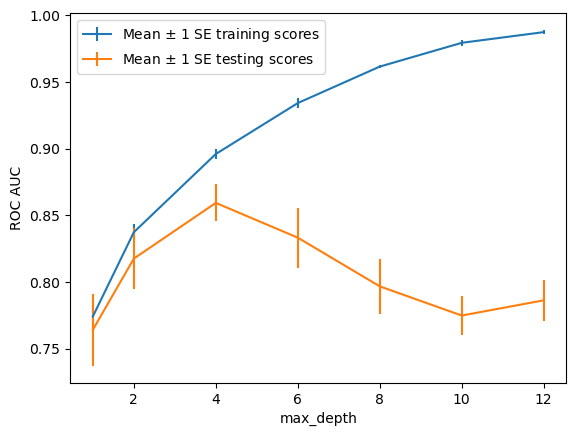

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'model__max_depth':[1, 2, 4, 6, 8, 10, 12]} #parameters

cv = GridSearchCV(pipeline, param_grid=params, scoring='roc_auc',
n_jobs=None, refit=True, cv=4, verbose=1,
error_score=np.nan,
return_train_score=True) # cv is the best model.
cv.fit(x_train, y_train)

cv_results_df = pd.DataFrame(cv.cv_results_)
#View the names of the remaining columns in the results DataFrame
cv_results_df.columns
fig, ax = plt.subplots()

ax.errorbar(cv_results_df['param_model__max_depth'],
cv_results_df['mean_train_score'],
yerr=cv_results_df['std_train_score']/np.sqrt(4),
label='Mean $\pm$ 1 SE training scores')
ax.errorbar(cv_results_df['param_model__max_depth'],
cv_results_df['mean_test_score'],
yerr=cv_results_df['std_test_score']/np.sqrt(4),
label='Mean $\pm$ 1 SE testing scores')
ax.legend()
plt.xlabel('max_depth')
plt.ylabel('ROC AUC')

<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\p'
C:\Users\MSI VN\AppData\Local\Temp\ipykernel_3968\130401419.py:26: SyntaxWarning: invalid escape sequence '\p'
  axs[1].set_ylabel('Mean testing ROC AUC $\pm$ 1 SE ')


Fitting 4 folds for each of 10 candidates, totalling 40 fits


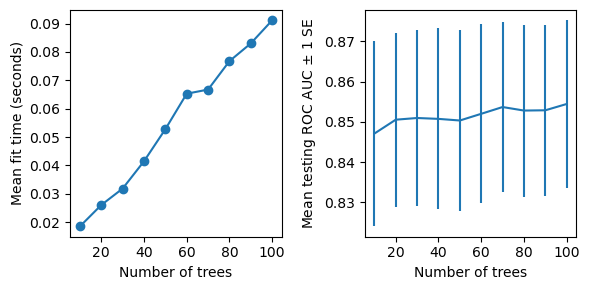

In [29]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=3,
                                    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                    max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                    bootstrap=True, oob_score=False, n_jobs=None,
                                    random_state=4, verbose=0, warm_start=False, class_weight=None))
])

rf_params_ex = {'model__n_estimators':list(range(10,110,10))}
cv_rf_ex = GridSearchCV(pipeline, param_grid=rf_params_ex,scoring='roc_auc', n_jobs=None,refit=True, cv=4, verbose=1,error_score=np.nan,return_train_score=True)

cv_rf_ex.fit(x_train, y_train)

cv_rf_ex_results_df = pd.DataFrame(cv_rf_ex.cv_results_)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].plot(cv_rf_ex_results_df['param_model__n_estimators'],
cv_rf_ex_results_df['mean_fit_time'],
'-o')
axs[0].set_xlabel('Number of trees')
axs[0].set_ylabel('Mean fit time (seconds)')
axs[1].errorbar(cv_rf_ex_results_df['param_model__n_estimators'],
cv_rf_ex_results_df['mean_test_score'],
yerr=cv_rf_ex_results_df['std_test_score']/np.sqrt(4))
axs[1].set_xlabel('Number of trees')
axs[1].set_ylabel('Mean testing ROC AUC $\pm$ 1 SE ')
plt.tight_layout()

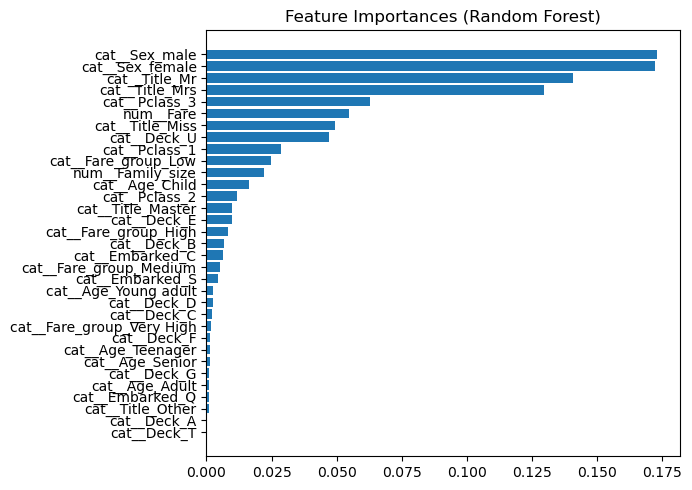

In [34]:
# Lấy model RandomForest
best_model = cv_rf_ex.best_estimator_
best_rf = best_model.named_steps['model']

# Lấy phần preprocessing trong pipeline (nếu có)
preprocessor = best_model.named_steps['preprocessor']

# Lấy tên các feature sau khi đã transform (one-hot, scale, v.v.)
feature_names = preprocessor.get_feature_names_out()

# Tạo DataFrame biểu diễn feature importances
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=True)

# Vẽ biểu đồ
plt.figure(figsize=(7, 5))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.title('Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

